In [1]:
!pip install transformers
!pip install -U sacremoses
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [2]:

import torch
import pandas as pd

from keras.preprocessing.sequence import pad_sequences
from transformers import (
    AdamW,
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

from IPython import display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
df = pd.read_excel('/content/hackaton_result_dataset.xlsx')
df.shape

(6508, 4)

In [5]:
category_index = {str(i[1]):int(i[0]) for i in enumerate(df.label.unique())}
category_index_reverce = {str(i[0]):int(i[1]) for i in enumerate(df.label.unique())}
category_index_reverce

{'0': 1, '1': 0}

In [6]:
sentences = df.model_annotation.values
labels = df.label.values
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [7]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'DeepPavlov/rubert-base-cased-conversational')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://h

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

(array([3.955e+03, 1.847e+03, 4.490e+02, 1.550e+02, 5.800e+01, 2.600e+01,
        8.000e+00, 4.000e+00, 3.000e+00, 3.000e+00]),
 array([ 3. ,  9.2, 15.4, 21.6, 27.8, 34. , 40.2, 46.4, 52.6, 58.8, 65. ]),
 <BarContainer object of 10 artists>)

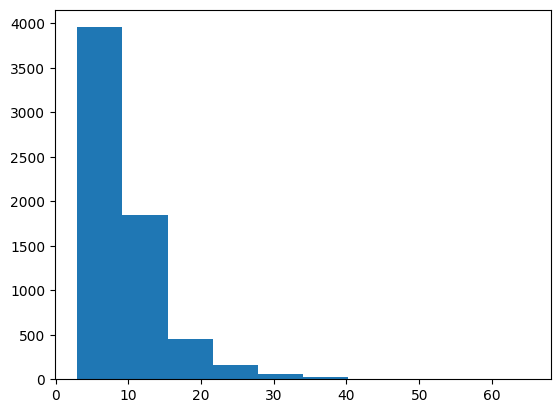

In [9]:
lenths = [len(sent) for sent in tokenized_texts]
plt.hist(lenths)

In [10]:
input_ids = pad_sequences(
    input_ids,
    maxlen=32,
    dtype='long',
    truncating='post',
    padding='post'
)

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [11]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
    input_ids,
    labels,
    attention_masks,
    random_state=42,
    test_size=0.1
)

In [12]:
class TokenizedDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, labels, masks):
        self.input_ids = input_ids
        self.labels = labels
        self.masks = masks

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx]).to(device),
            "attention_mask": torch.tensor(self.masks[idx]).to(device),
            "labels": torch.tensor(self.labels[idx]).to(device)
        }

train_dataset = TokenizedDataset(train_inputs, train_labels, train_masks)
eval_dataset = TokenizedDataset(validation_inputs, validation_labels, validation_masks)

In [13]:
training_args = TrainingArguments(
    output_dir="data",
    num_train_epochs=10,
    learning_rate=3e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    weight_decay=0.05,
    logging_steps=50,
    eval_steps=50,
    save_steps=50,
    evaluation_strategy="steps",
    remove_unused_columns=True,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
def get_metrics(eval_pred):
    label_ids = eval_pred.label_ids
    probs = eval_pred.predictions[:, 1]
    roc_auc = roc_auc_score(label_ids, probs)
    return {"roc_auc": roc_auc}

In [15]:
config = AutoConfig.from_pretrained(
    'DeepPavlov/rubert-base-cased-conversational',
    num_labels=2,
    id2label=category_index_reverce,
    label2id=category_index
)
model = AutoModelForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased-conversational', config=config, device_map=device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model.dropout = torch.nn.Dropout(p=0.7)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=get_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [18]:
trainer.train()

Step,Training Loss,Validation Loss,Roc Auc
50,0.700700,0.655625,0.666503
100,0.593700,0.541801,0.803879
150,0.506300,0.510801,0.824864
200,0.432800,0.570368,0.824681
250,0.319200,0.667936,0.813745
300,0.257300,0.825292,0.812666


TrainOutput(global_step=300, training_loss=0.46833434104919436, metrics={'train_runtime': 228.465, 'train_samples_per_second': 256.363, 'train_steps_per_second': 4.027, 'total_flos': 314203933422720.0, 'train_loss': 0.46833434104919436, 'epoch': 3.260869565217391})

In [19]:
log_history = {}

for log in trainer.state.log_history:
  if log['step'] not in log_history:
    log_history[log['step']] = {}

  if 'loss' in log:
    log_history[log['step']]['train_loss'] = log['loss']
  if 'eval_loss' in log:
    log_history[log['step']]['eval_loss'] = log['eval_loss']
    log_history[log['step']]['eval_roc_auc'] = log['eval_roc_auc']

history = {
    'steps': [],
    'train_loss': [],
    'eval_loss': [],
    'eval_roc_auc': []
}

for step, values in log_history.items():
  history['steps'].append(step)
  history['train_loss'].append(values['train_loss'])
  history['eval_loss'].append(values['eval_loss'])
  history['eval_roc_auc'].append(values['eval_roc_auc'])

history

{'steps': [50, 100, 150, 200, 250, 300],
 'train_loss': [0.7007, 0.5937, 0.5063, 0.4328, 0.3192, 0.2573],
 'eval_loss': [0.6556248068809509,
  0.541800856590271,
  0.510800838470459,
  0.5703679919242859,
  0.6679360866546631,
  0.8252916932106018],
 'eval_roc_auc': [0.6665028712375227,
  0.8038790611631403,
  0.824864146144063,
  0.8246810806644315,
  0.8137453270127568,
  0.8126662041854549]}

In [20]:
def plot_history(history):

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(history['steps'], history["train_loss"], "b", label="train_loss")
    plt.plot(history['steps'], history["eval_loss"], "r", label="eval_loss")
    plt.legend(loc="upper left")
    plt.title("Loss")


    plt.subplot(1, 2, 2)
    plt.plot(history['steps'], history["eval_roc_auc"], "b", label="eval_roc_auc")
    plt.legend(loc="upper left")
    plt.title("ROC AUC")

    display.display(plt.gcf())
    display.clear_output(wait=True)

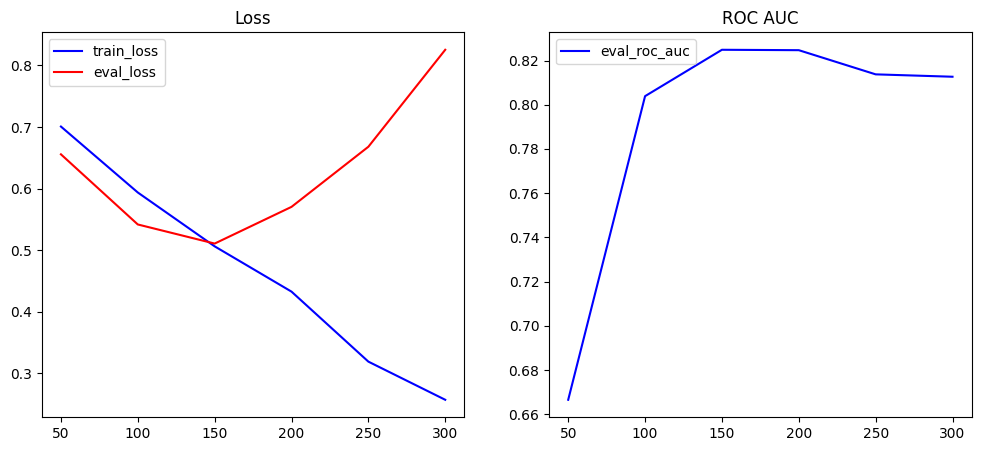

In [21]:
plot_history(history)

In [22]:
trainer.save_model("/content/best_model")

In [25]:
!zip -r /content/best_model.zip /content/best_model

  adding: content/best_model/ (stored 0%)
  adding: content/best_model/model.safetensors (deflated 8%)
  adding: content/best_model/tokenizer.json (deflated 73%)
  adding: content/best_model/training_args.bin (deflated 51%)
  adding: content/best_model/config.json (deflated 54%)
  adding: content/best_model/tokenizer_config.json (deflated 75%)
  adding: content/best_model/special_tokens_map.json (deflated 42%)
  adding: content/best_model/vocab.txt (deflated 65%)


In [26]:
from google.colab import files
files.download("/content/best_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>